In [1]:
# 보팅, 배깅
# 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식
# 보팅
# 서로 다른 알고리즘을 가진 분류기를 결합하는 것
# 배깅
# 각각의 분류기가 모두 같은 유형의 알고리즘 기반이지만, 데이터 샘플링을 서로 다르게 가져가면서 학습을 수애행 보팅을 
# 수행하는 것
# 부스팅
# 여러 개의 분류기가 순차적으로 학습을 수행하되, 앞에서 학습한 분류기가 에측이 틀린데이터에 대해서는 올바르게 예측할 수
# 있도록 다음 분류기에게는 가중치를 부여하면서 학습과 예측을 진행하는 것

In [3]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [4]:
# 개별 모델은 로지스틱 회귀와 KNN임.
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors = 8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators = [("LR", lr_clf), ("KNN", knn_clf)], voting = "soft")

x_train, x_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   test_size = 0.2, random_state = 156)

# VotingClassifier 학습/예측/평가.
vo_clf.fit(x_train, y_train)
pred = vo_clf.predict(x_test)
print("Voting 분류기 정확도 : {0:.4f}".format(accuracy_score(y_test, pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(x_train, y_train)
    pred = classifier.predict(x_test)
    class_name = classifier.__class__.__name__
    print("{0} 정확도 : {1:.4f}".format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도 : 0.9474
LogisticRegression 정확도 : 0.9386
KNeighborsClassifier 정확도 : 0.9386


In [9]:
# 부트스트래핑 분할방식
# 여러 개의 데이터 세트를 중첩되게 분리하는 것
# 부트스트랩
# 여러 개의 작은 데이터 세트를 임의로 만들어 개별 평균의 분포도를 측정하는 등의 목적을 위한 샘프링 방식
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby("column_name").cumcount(),
                                 columns = ["dup_cnt"])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df,
                                  how = "outer")
    new_feature_name_df["column_name"] = new_feature_name_df[["column_name",
                                                             "dup_cnt"]].apply(lambda x : x[0] + "_" + str(x[1])
                                                                              if x[1] > 0 else x[0], axis = 1)
    new_feature_name_df = new_feature_name_df.drop(["index"], axis = 1)
    return new_feature_name_df

def get_human_dataset():
    
    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep로 할당.
    feature_name_df = pd.read_csv("../../data/human_activity/features.txt", sep = "\s+",
                                 header=None, names = ["column_index", "column_name"])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 칼럼으로 부여학 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    x_train = pd.read_csv("../../data/human_activity/train/X_train.txt", sep = "\s+", names = feature_name)
    x_test = pd.read_csv("../../data/human_activity/test/X_test.txt", sep = "\s+", names = feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv("../../data/human_activity/train/y_train.txt", sep="\s+",header=None, names=["action"])
    y_test = pd.read_csv("../../data/human_activity/test/y_test.txt", sep="\s+",header=None, names=["action"])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return x_train, x_test, y_train, y_test

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# 결정 트리에서 사용한 get_human_dataset()를 이용해 학습/테스트용 DataFrame 반환
x_train, x_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(x_train, y_train)
pred = rf_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print("랜덤 포레스트 정확도 : {0:.4f}".format(accuracy))

랜덤 포레스트 정확도 : 0.9253


In [11]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators":[100],
    "max_depth":[6,8,10,12],
    "min_samples_leaf":[8,12,18],
    "min_samples_split":[8,16,20]
}
# RandomForestClassifier 객체 생성 후 GrdiSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(x_train, y_train)

print("최적 하이퍼 파라미터:\n", grid_cv.best_params_)
print("최고 예측 정확도: {0:.4f}".format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [12]:
rf_clf1 = RandomForestClassifier(n_estimators = 300, max_depth = 10, 
                                min_samples_split = 8, min_samples_leaf = 8, random_state=0)
rf_clf1.fit(x_train, y_train)
pred = rf_clf1.predict(x_test)
print("예측 정확도 : {0:.4f}".format(accuracy_score(y_test, pred)))

예측 정확도 : 0.9165


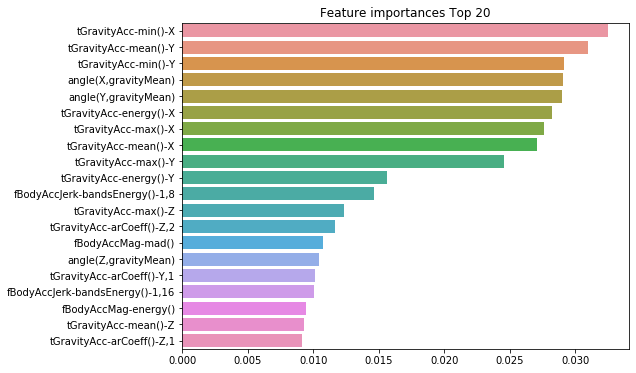

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8,6))
plt.title("Feature importances Top 20")
sns.barplot(x=ftr_top20, y=ftr_top20.index)


In [14]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings("ignore")

x_train, x_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(x_train, y_train)
gb_pred = gb_clf.predict(x_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print("GBM 정확도: {0:.4f}".format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초".format(time.time() - start_time))

GBM 정확도: 0.9393
GBM 수행 시간: 656.8 초


In [ ]:
from sklearn.model_selection import GrdiSearchCV

params = {
    "n_estimators" : [100, 500],
    "learning_rate" : [0.05, 0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid = params, cv = 2, verbose = 1)
grid_cv.fit(x_train, y_train)
print("최적 하이퍼 파라미터:\n", grid_cv.best_params_)
print("최고 예측 정확도: {0:.4f}".format(grid_cv.best_score_))

In [ ]:
# XGBoost
# 분류에 있어서 일반적으로 다른 머신러닝보다 뛰어난 예측 성능을 나타냄

In [15]:
import xgboost as xgb
from xgboost import XGBClassifier

In [16]:
# xgboost 파라미터
# bosster
# silent : 출력 메시지를 나타내고 싶지 않을 겨우 1로 설정
# nthread : CPU의 실행 스레드 개수를 조정
# learning_rate : 학습률
# n_estimators : 약한가지 갯수
# min_child_weight : 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 가중치 합
# gamma : 최소 손실 감소 값(값이 클수록 과적합 감소효과)
# max_depth : 트리 깊이 지정
# subsample : 샘플링하는 비율 지정
# colsample_bytree : max_features
# reg_lambda : L2 규제
# reg_alpha : L1 규제
# scale_pos_weight : 불균형 데이터 세트의 균형 유지를 위한 파라미터
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
x_features = dataset.data
y_label = dataset.target

x_train, x_test, y_train, y_test = train_test_split(x_features, y_label,
                                                   test_size = 0.2, random_state = 156)

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("오차행렬")
    print(confusion)
    # ROC-AUC pring 추가
    print("정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}"
          .format(accuracy, precision, recall, f1, roc_auc))

In [23]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimator = 400, learing_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(x_train, y_train)
w_preds = xgb_wrapper.predict(x_test)
w_pred_proba = xgb_wrapper.predict_proba(x_test)[:,1]
get_clf_eval(y_test, w_preds, w_pred_proba)

[22:36:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { learing_rate, n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


오차행렬
[[35  2]
 [ 2 75]]
정확도:0.9649, 정밀도:0.9740, 재현율:0.9740, F1:0.9740, AUC:0.9958


In [25]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learing_rate = 0.1, max_depth = 3)
evals = [(x_test, y_test)]
xgb_wrapper.fit(x_train, y_train, early_stopping_rounds = 100, eval_metric="logloss",
               eval_set = evals, verbose = True)
ws100_preds = xgb_wrapper.predict(x_test)
ws_100_pred_proba = xgb_wrapper.predict_proba(x_test)[:,1]

[22:39:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.47984
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.36218
[2]	validation_0-logloss:0.29004
[3]	validation_0-logloss:0.23382
[4]	validation_0-logloss:0.19901
[5]	validation_0-logloss:0.17469
[6]	validation_0-logloss:0.15549
[7]	validation_0-logloss:0.13367
[8]	validation_0-logloss:0.12411
[9]	validation_0-logloss:0.11611
[10]	validation_0-logloss:0.10768
[11]	validation_0-logloss:0.10018
[12]	validation_0-logloss:0.09754
[13]	validation_0-logloss:0.08920
[14]	validation_0-logloss:0.09259
[15]	validation_0-logloss:0.09144
[16]	validation_0-logloss:0.09066
[

In [26]:
get_clf_eval(y_test, ws100_preds, ws_100_pred_proba)

오차행렬
[[35  2]
 [ 3 74]]
정확도:0.9561, 정밀도:0.9737, 재현율:0.9610, F1:0.9673, AUC:0.9961


In [27]:
# early_stopping_rounds를 10으로 설정하고 재학습.
xgb_wrapper.fit(x_test, y_test, early_stopping_rounds = 10,
               eval_metric = "logloss", eval_set = evals, verbose = True)

ws10_preds = xgb_wrapper.predict(x_test)
ws10_pred_porba = xgb_wrapper.predict_proba(x_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_porba)

[22:41:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.47902
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.35869
[2]	validation_0-logloss:0.27721
[3]	validation_0-logloss:0.22113
[4]	validation_0-logloss:0.17888
[5]	validation_0-logloss:0.14323
[6]	validation_0-logloss:0.11928
[7]	validation_0-logloss:0.10080
[8]	validation_0-logloss:0.08699
[9]	validation_0-logloss:0.07417
[10]	validation_0-logloss:0.06607
[11]	validation_0-logloss:0.05963
[12]	validation_0-logloss:0.05341
[13]	validation_0-logloss:0.04833
[14]	validation_0-logloss:0.04418
[15]	validation_0-logloss:0.04058
[16]	validation_0-logloss:0.03774
[1

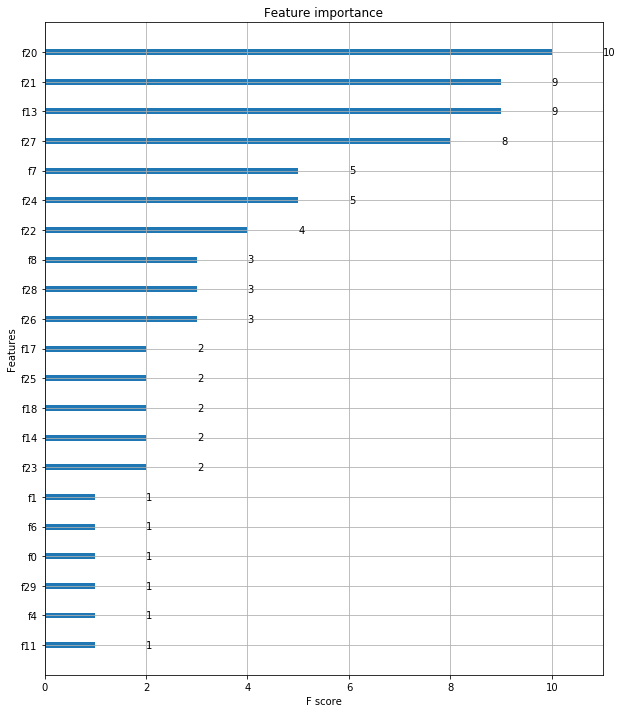

In [28]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 Wrapper 클래스를 입력해도 무방.
plot_importance(xgb_wrapper, ax=ax)

In [29]:
# LightGBM의 단점
# 10000개 이하의 데이터 포인트에 적용 시 과적합이 쉽게 발생
# Leaf Wise 리프 중심 트리 분할
# 카테고리형 피처의 자동 변환과 처적분활(원-핫 인코딩 사용이 필요 없음)
!pip install lightgbm

     |████████████████████████████████| 1.0 MB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/Users/mac/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [30]:
# LightGBM 하이퍼 파라미터
# n_estimators : 반복 수행하려는 트리의 개수
# learning_rate
# max_depth
# min_child_samples
# num_leaves : 하나의 트리가 가질 수 있는 최대 리프 개수
# boosting: 부스팅의 트리를 생성하는 알고리즘(default = gbdt)
# subsample : 트리가 커져서 과적합되는 것을 제어하기 위해서 데이터를 샘플링하는 비율
# colsample_bytree : 무직로 선택하는 피처의 비율
# reg_lambda
# reg_alpha

# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
x_train, x_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2,
                                                   random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimaotrs = 400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(x_test, y_test)]
lgbm_wrapper.fit(x_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                eval_set=evals, verbose = True)
preds = lgbm_wrapper.predict(x_test)
pred_proba = lgbm_wrapper.predict_proba(x_test)[:,1]

[LightGBM] [Warning] Unknown parameter: n_estimaotrs
[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's

In [31]:
get_clf_eval(y_test, preds, pred_proba)

오차행렬
[[33  4]
 [ 1 76]]
정확도:0.9561, 정밀도:0.9500, 재현율:0.9870, F1:0.9682, AUC:0.9905


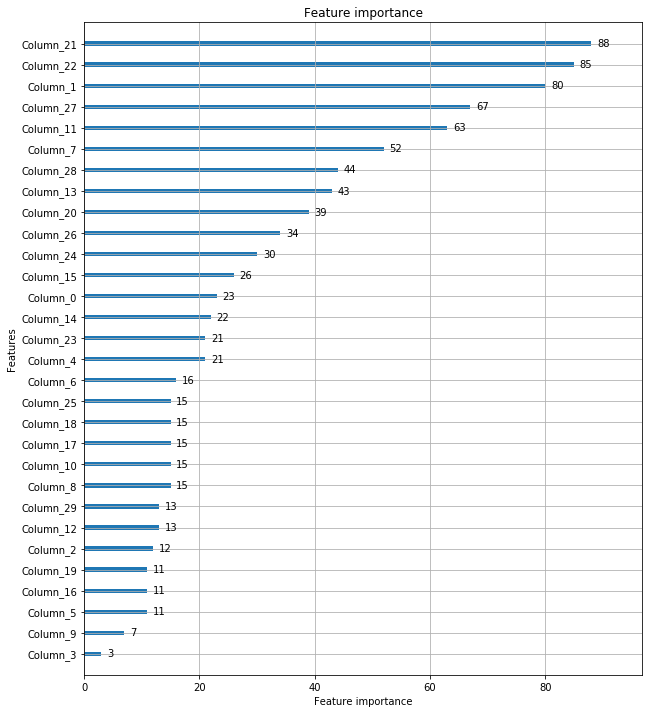

In [32]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(lgbm_wrapper, ax=ax)